In [9]:
import torch
import matplotlib.pyplot as plt
from accelerate import Accelerator
from tqdm import tqdm

from m2_utilities.load_data import load_trajectories
from m2_utilities.qwen import load_qwen
from m2_utilities.metrics import gen_points, compute_metrics
from m2_utilities.preprocessor import Preprocessor
from m2_utilities.flops import compute_flops_gen


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the Model and Data

In [3]:
# Model
model, tokenizer = load_qwen()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [10]:
# Loading trajectories
trajectories = load_trajectories("data/lotka_volterra_data.h5")

test_trajectories = trajectories[850:]

### Visualising Autoregressive Inference of Time Points

In [11]:
future_points = gen_points(model, test_trajectories[3:4, :55], n_points=25, decimals=2)

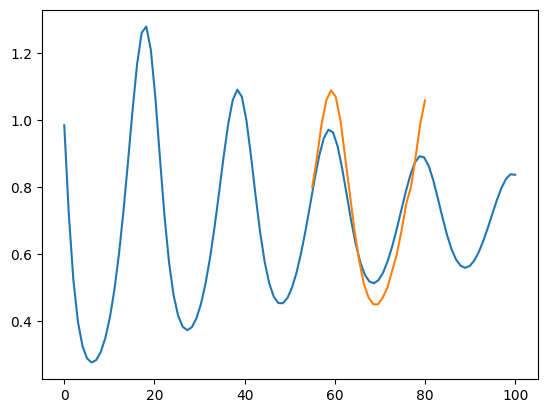

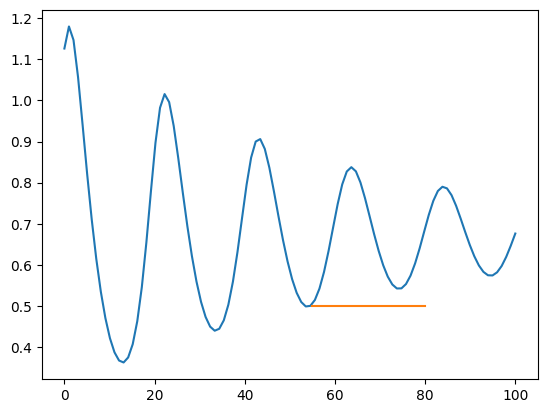

In [12]:
N_FORECAST = 25
plt.plot(torch.linspace(0, 100, 100), test_trajectories[3, :, 0])
plt.plot(torch.linspace(55, 55 + N_FORECAST, N_FORECAST), future_points[0, :, 0])
plt.show()

plt.plot(torch.linspace(0, 100, 100), test_trajectories[3, :, 1])
plt.plot(torch.linspace(55, 55 + N_FORECAST, N_FORECAST), future_points[0, :, 1])
plt.show()

### Computing MAE/MRAE Metrics

In [13]:
future_points = gen_points(model, test_trajectories[:, :80], n_points=20, decimals=2)

Predator MAEs: 0.5151277780532837
Prey MAEs: 0.25240445137023926


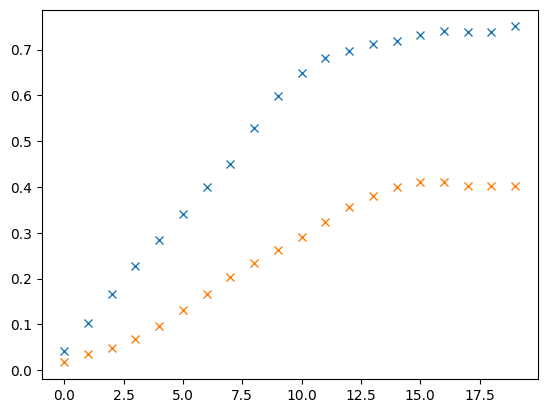

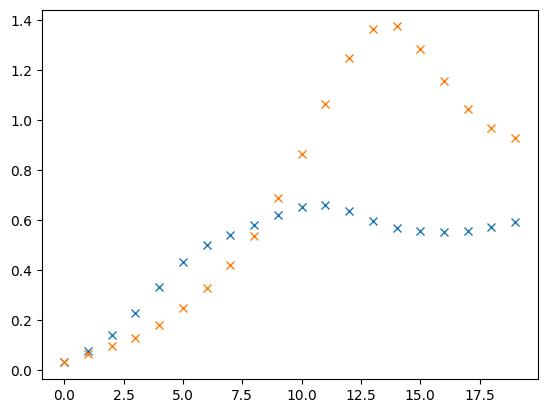

In [16]:
pred_maes, prey_maes, pred_mraes, prey_mraes = compute_metrics(test_trajectories[:, 80:], future_points)

print(f"Predator MAEs: {torch.mean(pred_maes)}")
print(f"Prey MAEs: {torch.mean(prey_maes)}")

plt.plot(torch.linspace(0, 19, 20), pred_maes, "x")
plt.plot(torch.linspace(0, 19, 20), prey_maes, "x")
plt.show()

plt.plot(torch.linspace(0, 19, 20), pred_mraes, "x")
plt.plot(torch.linspace(0, 19, 20), prey_mraes, "x")
plt.show()